# On Analyzing Real World Time Series for Forecasting Stock Data
- Reference: real_world_investigation-base.ipynb

In [1]:
from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, AR, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
    - Returns = log difference
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive AR(p) Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2013-01-01", "2023-10-16"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("^GSPC", "S&P 500"),
    ("AAPL", "Apple"),
    ("WMT", "Walmart")
]
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, start_date=start_date, end_date=end_date) for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = 'WMT'
col = 'Close'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Open))

In [5]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([ 68.93000031,  69.25      ,  68.73000336, ..., 158.25999451,
       158.52999878, 159.25999451])

In [6]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

Open
Date                  
2013-01-02   68.930000
2013-01-03   69.250000
2013-01-04   68.730003
2013-01-07   68.830002
2013-01-08   68.279999
...                ...
2023-10-09  155.080002
2023-10-10  156.229996
2023-10-11  158.259995
2023-10-12  158.529999
2023-10-13  159.259995

[2715 rows x 1 columns]

### Plot Raw Data

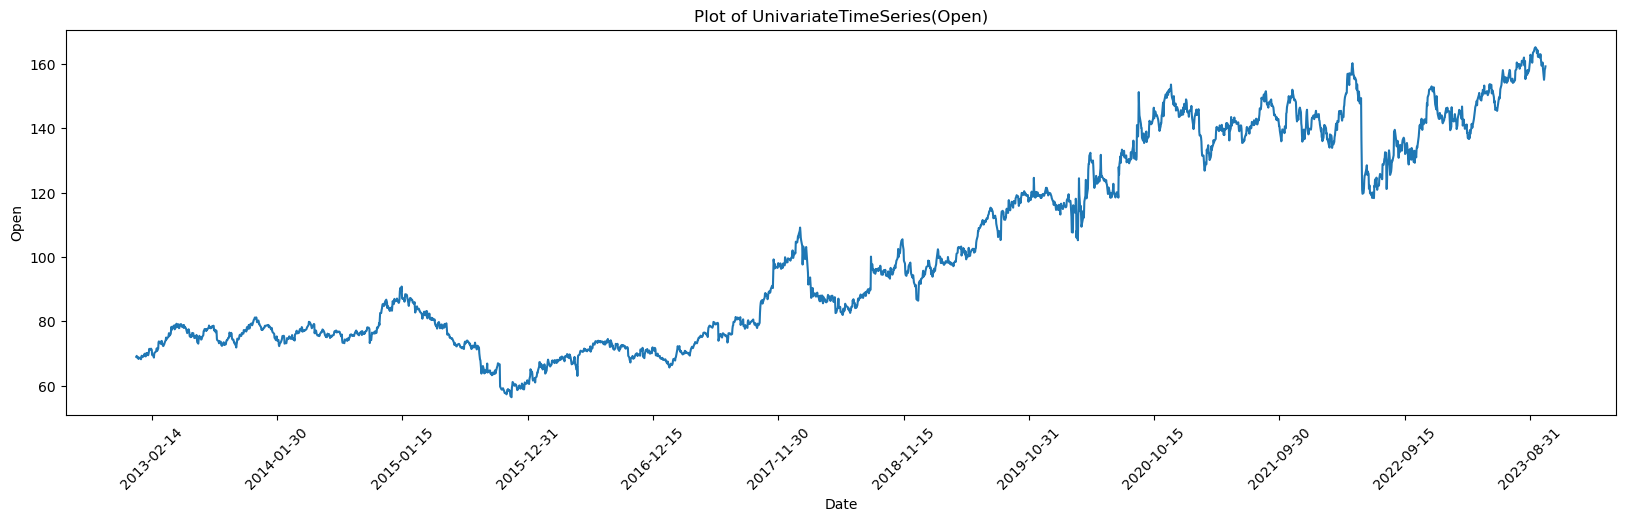

In [7]:
stocks[stock_symbol].plot(tick_skip=350)

### Get Descriptive Statistics of Raw Data

In [8]:
stocks[stock_symbol].get_statistics()

Open
count  2715.000000
mean    102.222597
std      30.650945
min      56.389999
25%      75.395000
50%      92.050003
75%     134.105003
max     165.210007

In [9]:
stocks[stock_symbol].max_min_range()

{'Max': Open    165.210007
 dtype: float64,
 'Min': Open    56.389999
 dtype: float64,
 'Range': Open    108.820007
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [10]:
stocks[stock_symbol].stationarity_test(stock_df)

Series is non-stationary as 0.8459770610115512 > 0.05


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

- Below, there seems to be a high ACor, which means there's NOT such a difference between our 1st observation and k-th lag observation
    - What to do with this?  We must take the `returns`.
- The Partial ACor dies out after 2. Why?

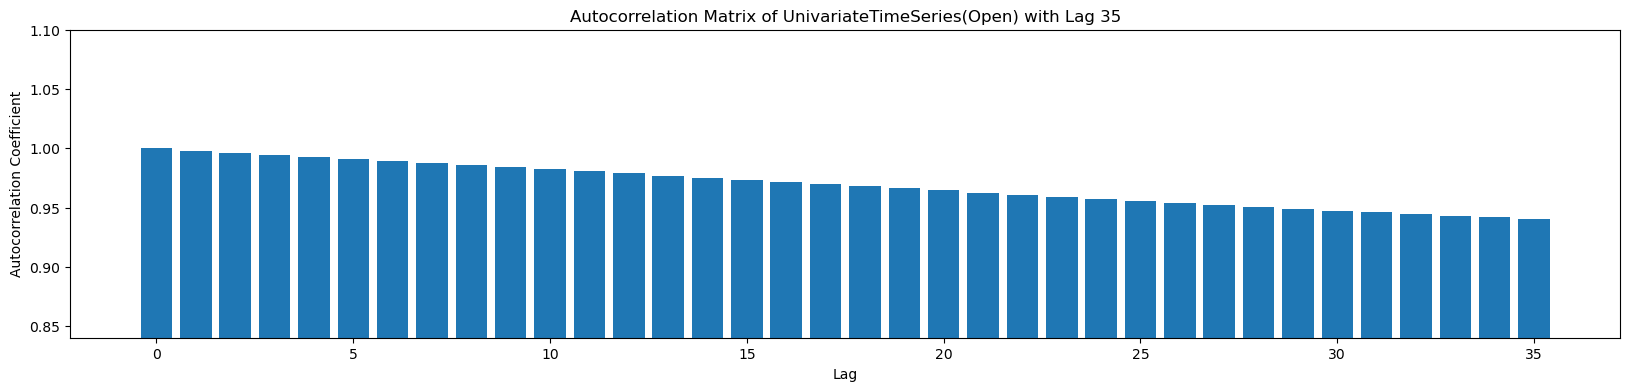

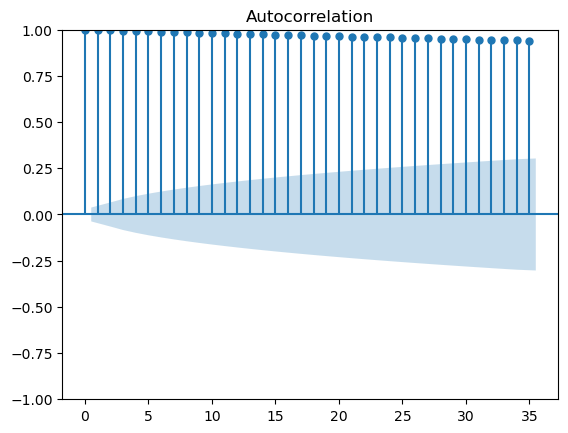

In [11]:
stocks[stock_symbol].plot_autocorrelation(35)

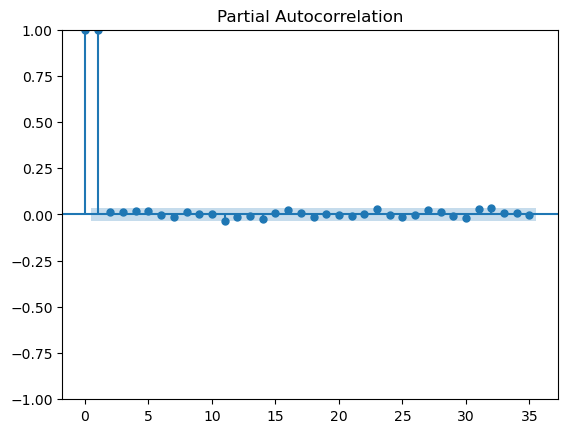

In [12]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

### Get Returns Data

- Forecast returns
- Why: To have more stationarity (for the returns) compared to the prices `Open`/`Close` which is non-stationary
- Calculate with the `change` between $ z_t $ and $ z_{t-1} $
$$ Change = ((z_t - z_{t-1}) \div | z_{t-1} |) \space \rightarrow decimal \space form $$
$$ Percent \space Change = Change \times 100 \space \rightarrow pecent \space form $$
    - If `change` < 0, then stock price is going down, hence a **loss** from $ z_{t-1} \rightarrow z_t $
    - If `change` > 0, then stock price is going up, hence a **gain** from $ z_{t-1} \rightarrow z_t $
    - If `change` = 0, then stock price is constant, hence a **no loss nor no gain** from $ z_{t-1} \rightarrow z_t $
- NOTE: Shift the date by 1 because we don't have anything to subtract the 0th date by.

In [13]:
stock_returns = stocks[stock_symbol].data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

In [14]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

Returns
Date                
2013-01-03  0.004642
2013-01-04 -0.007509
2013-01-07  0.001455
2013-01-08 -0.007991
2013-01-09  0.005565
...              ...
2023-10-09 -0.022502
2023-10-10  0.007415
2023-10-11  0.012994
2023-10-12  0.001706
2023-10-13  0.004605

[2714 rows x 1 columns]

### Plot Returns Data

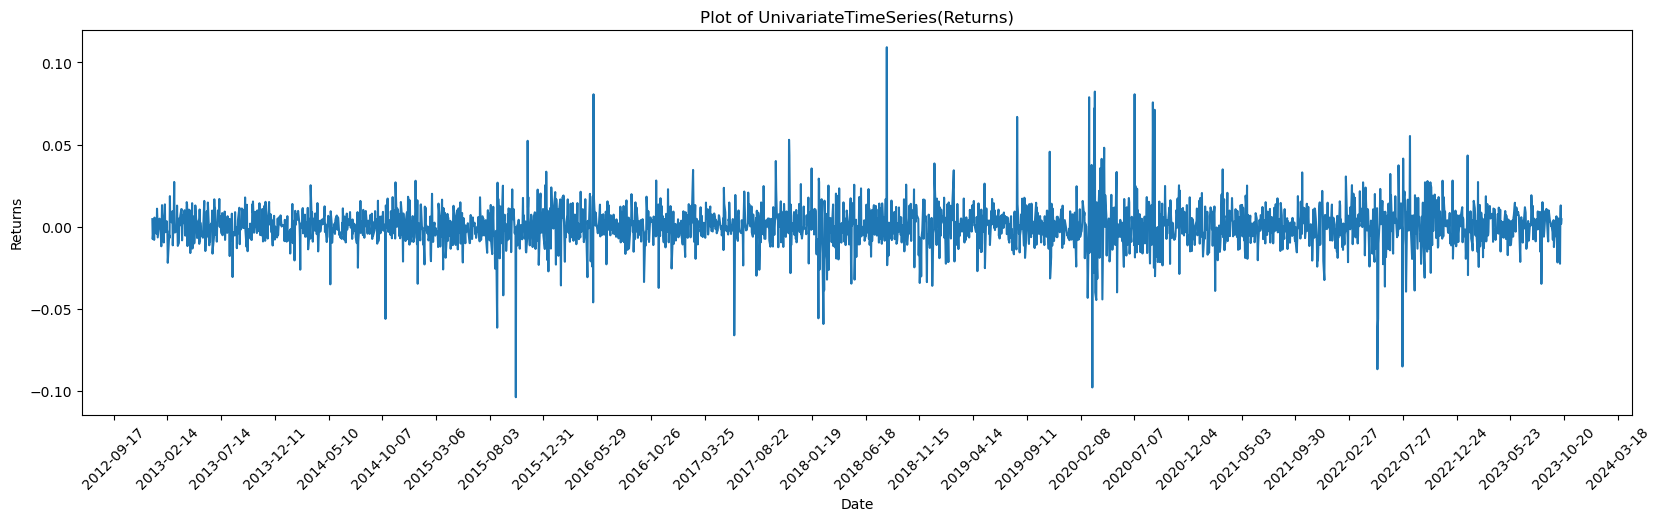

In [15]:
stock_returns.plot(tick_skip=150)

### Get Descriptive Statistics of Returns Data

In [16]:
stock_returns.get_statistics()

Returns
count  2714.000000
mean      0.000390
std       0.012739
min      -0.103738
25%      -0.005684
50%       0.000268
75%       0.006510
max       0.109252

### Check Stationarity of Returns Data
- adfuller. See documentation

In [17]:
stock_returns.stationarity_test(stock_returns_df)

Series is stationary as 0.0 < 0.05


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

- Below, the ACor between our 1st observation and k-th lag observation is low. This ACor resembles the Raw Data Partial ACor plot. Why?
- The Partial ACor is similar (to the Raw Data Partial ACor plo), except it here, it dies out at 2 (compared to the Raw Data Partial ACor plot which dies out after 2). Why?

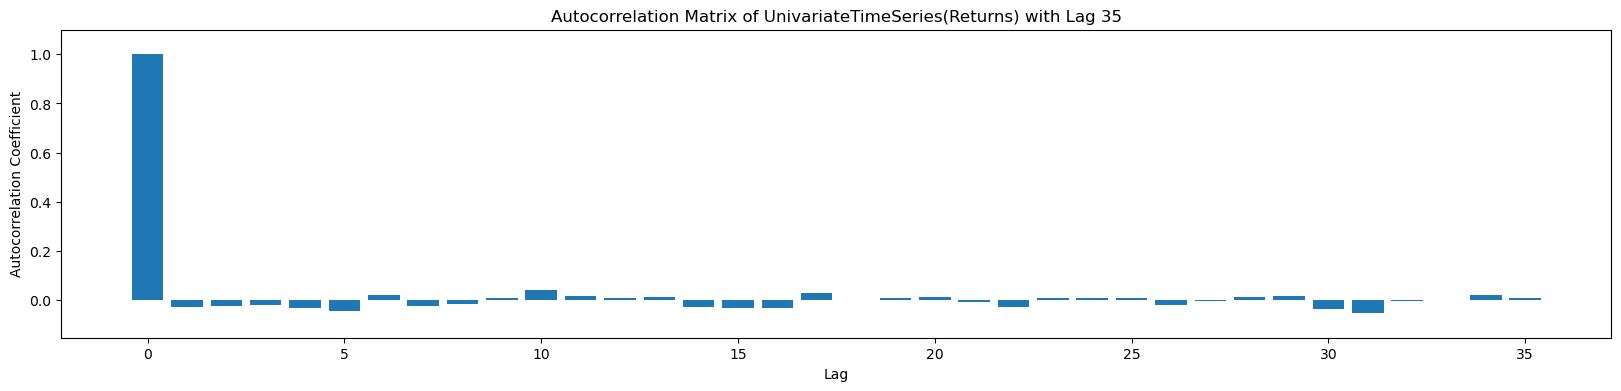

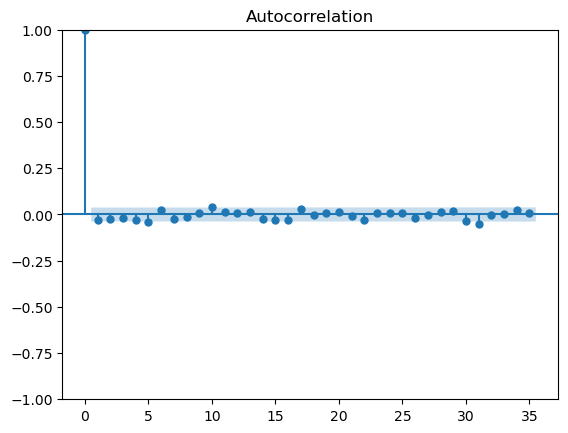

In [18]:
stock_returns.plot_autocorrelation(35)

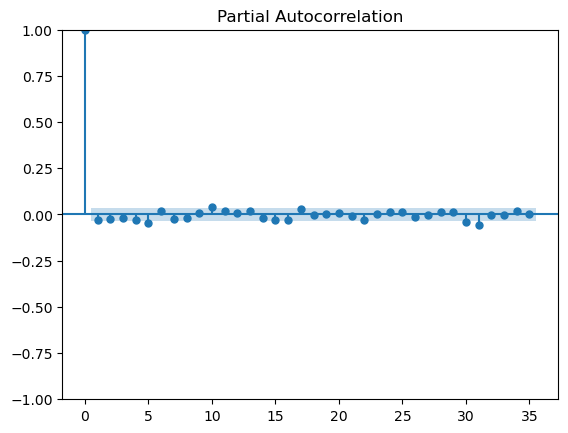

In [19]:
stock_returns.plot_partial_autocorrelation(35)

### Split Returns Data

- Splitting so we can forecast the last 7 days. Do this type of forecast to see how model is performing. If model performs how we need, then update notebook to forecast the next 7 days.

In [20]:
stock_returns_len = len(stock_returns_df)
stock_returns_len

2714

In [21]:
get_train_len = len(stock_returns_df[:2700])
get_train_len

2700

In [22]:
get_train_percentage = float(get_train_len / stock_returns_len)
get_train_percentage

0.9948415622697127

In [23]:
train, validation, test = stock_returns.get_train_validation_test_split(get_train_percentage, 0.0)

0 2700
2700 2700
2700 2714


In [24]:
train

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[0:2700])

In [25]:
train.get_as_df()

UnivariateTimeSeries(Returns)[0:2700]
Date                                             
2013-01-03                               0.004642
2013-01-04                              -0.007509
2013-01-07                               0.001455
2013-01-08                              -0.007991
2013-01-09                               0.005565
...                                           ...
2023-09-19                              -0.007894
2023-09-20                               0.001347
2023-09-21                               0.004034
2023-09-22                              -0.012358
2023-09-25                               0.000863

[2700 rows x 1 columns]

In [26]:
validation

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[2700:2700])

In [27]:
validation.get_as_df()

Empty DataFrame
Columns: [UnivariateTimeSeries(Returns)[2700:2700]]
Index: []

In [28]:
test

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[2700:2714])

In [29]:
test.get_as_df()

UnivariateTimeSeries(Returns)[2700:2714]
Date                                                
2023-09-26                                  0.003511
2023-09-27                                 -0.005769
2023-09-28                                  0.000000
2023-09-29                                  0.006358
2023-10-02                                 -0.021714
2023-10-03                                  0.001254
2023-10-04                                 -0.000251
2023-10-05                                  0.005011
2023-10-06                                 -0.011218
2023-10-09                                 -0.022502
2023-10-10                                  0.007415
2023-10-11                                  0.012994
2023-10-12                                  0.001706
2023-10-13                                  0.004605

In [30]:
expected_forecast = test.get_series()
expected_forecast

array([ 0.00351055, -0.00576901,  0.        ,  0.00635802, -0.02171375,
        0.00125398, -0.00025054,  0.00501098, -0.01121847, -0.02250231,
        0.00741549,  0.01299366,  0.00170608,  0.00460478])

### Initialize Autoregressive AR(p) Model

- How to determine the proper lag value? Look at the Partial ACor plot. Being that we're out of the blue area at lag 3, we'll set our lag to be 3.
    - Why Partial ACor plot and not ACor plot?
    - What if we take lags from ACor plot anyway? Say lags 5, 10, and 15 because they all have the most correlation (postive and negative) for their clusters, respectfully.
- How to understand the model summary?

In [31]:
positive_pacor = [6, 12, 17]
negative_pacor = [2, 16, 22, 33]
lags_to_test = positive_pacor + negative_pacor
lags_to_test = sorted(lags_to_test)
lags_to_test

[2, 6, 12, 16, 17, 22, 33]

In [32]:
# create an object from the AR() class
ar_model_class = AR()

# call the function to train our AR model
trained_ar_models = ar_model_class.train_ar_model(train.get_series(), lags_to_test)

Model 1 with a lag of 2
Model 2 with a lag of 6
Model 3 with a lag of 12
Model 4 with a lag of 16
Model 5 with a lag of 17
Model 6 with a lag of 22
Model 7 with a lag of 33


In [33]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data

2700

### Predict Forecasts of Retruns Data

In [34]:
predictions = ar_model_class.predict(trained_ar_models, len_historical_data, train, test)
predictions

Model 1 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a04dc550>
Model 2 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a044cb50>
Model 3 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a043f940>
Model 4 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a04599a0>
Model 5 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a0393850>
Model 6 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a03c1520>
Model 7 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a0246820>


[array([0.00070358, 0.0003801 , 0.00039308, 0.00040074, 0.00040021,
        0.00040003, 0.00040005, 0.00040005, 0.00040005, 0.00040005,
        0.00040005, 0.00040005, 0.00040005, 0.00040005]),
 array([0.00093195, 0.0003383 , 0.00065848, 0.0010243 , 0.00010095,
        0.00037392, 0.00040027, 0.00037469, 0.00038882, 0.00042871,
        0.00039707, 0.00040135, 0.00040237, 0.00040046]),
 array([ 1.16526379e-03,  5.64934383e-04,  9.95550356e-04,  1.14180428e-03,
        -2.27419995e-04,  2.32988427e-04,  4.67102272e-04,  3.18937614e-04,
        -2.98945111e-05,  2.79729346e-04,  2.88274496e-04,  4.47175122e-04,
         4.79895054e-04,  4.60415490e-04]),
 array([ 1.35449341e-03,  9.42903473e-04,  8.21859548e-04,  5.23203917e-04,
        -6.21429497e-04,  5.41727404e-05,  3.73935386e-04,  2.27998241e-04,
        -7.93482063e-05,  5.95224080e-04,  7.19844933e-04,  3.99452758e-04,
         6.27379952e-04,  6.72875393e-04]),
 array([ 1.49132601e-03,  1.24197984e-03,  6.41662960e-04,  2.825907

In [35]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecast, predictions)
mse_gsts

expected [ 0.00351055 -0.00576901  0.          0.00635802 -0.02171375  0.00125398
 -0.00025054  0.00501098 -0.01121847 -0.02250231  0.00741549  0.01299366
  0.00170608  0.00460478] predicted [0.00070358 0.0003801  0.00039308 0.00040074 0.00040021 0.00040003
 0.00040005 0.00040005 0.00040005 0.00040005 0.00040005 0.00040005
 0.00040005 0.00040005] mse 0.010279951446307022
expected [ 0.00351055 -0.00576901  0.          0.00635802 -0.02171375  0.00125398
 -0.00025054  0.00501098 -0.01121847 -0.02250231  0.00741549  0.01299366
  0.00170608  0.00460478] predicted [0.00093195 0.0003383  0.00065848 0.0010243  0.00010095 0.00037392
 0.00040027 0.00037469 0.00038882 0.00042871 0.00039707 0.00040135
 0.00040237 0.00040046] mse 0.010209121331345663
expected [ 0.00351055 -0.00576901  0.          0.00635802 -0.02171375  0.00125398
 -0.00025054  0.00501098 -0.01121847 -0.02250231  0.00741549  0.01299366
  0.00170608  0.00460478] predicted [ 1.16526379e-03  5.64934383e-04  9.95550356e-04  1.14180428e

### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

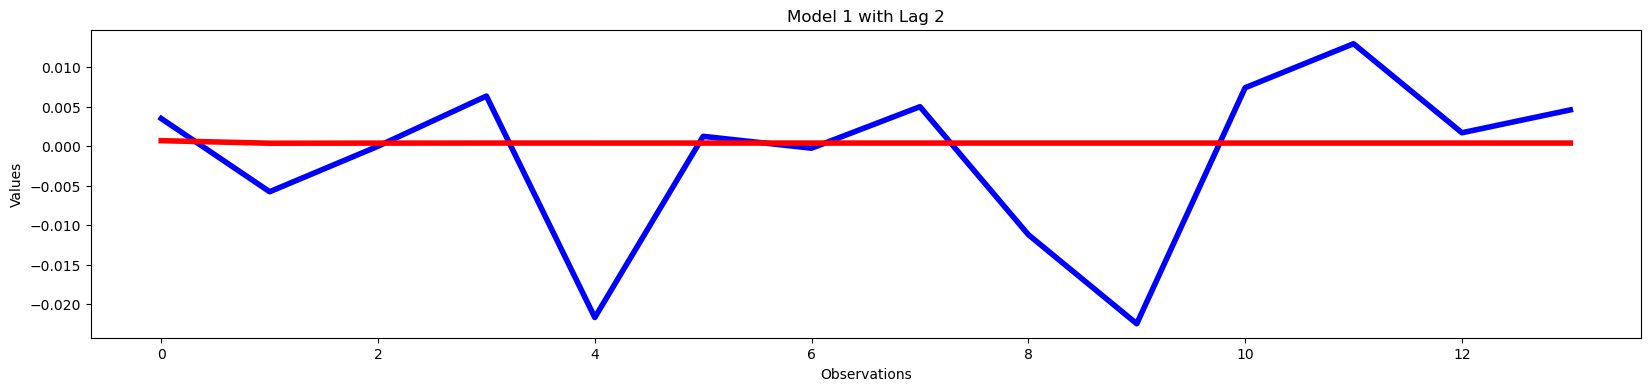

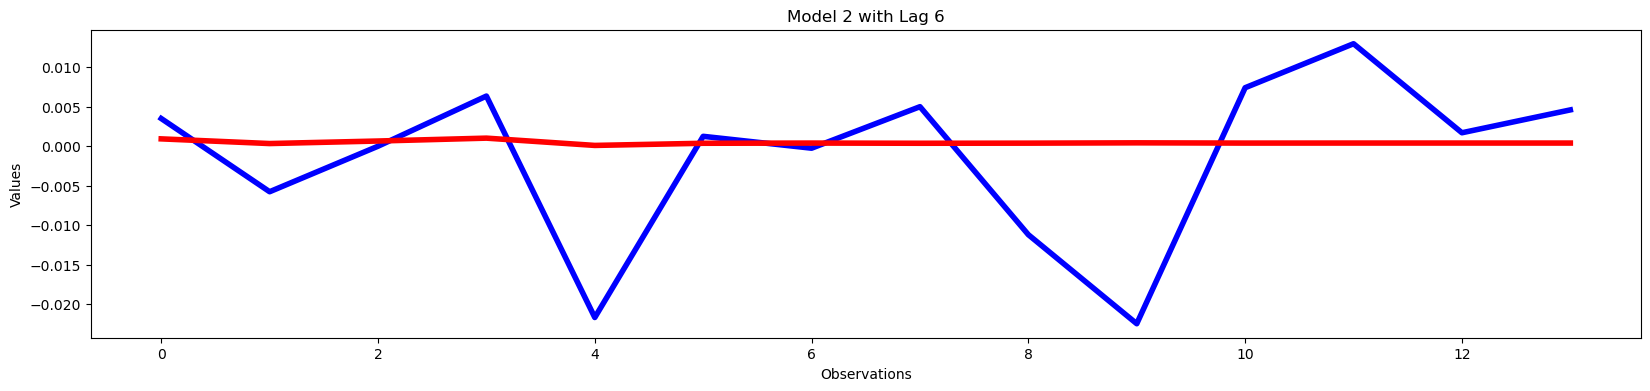

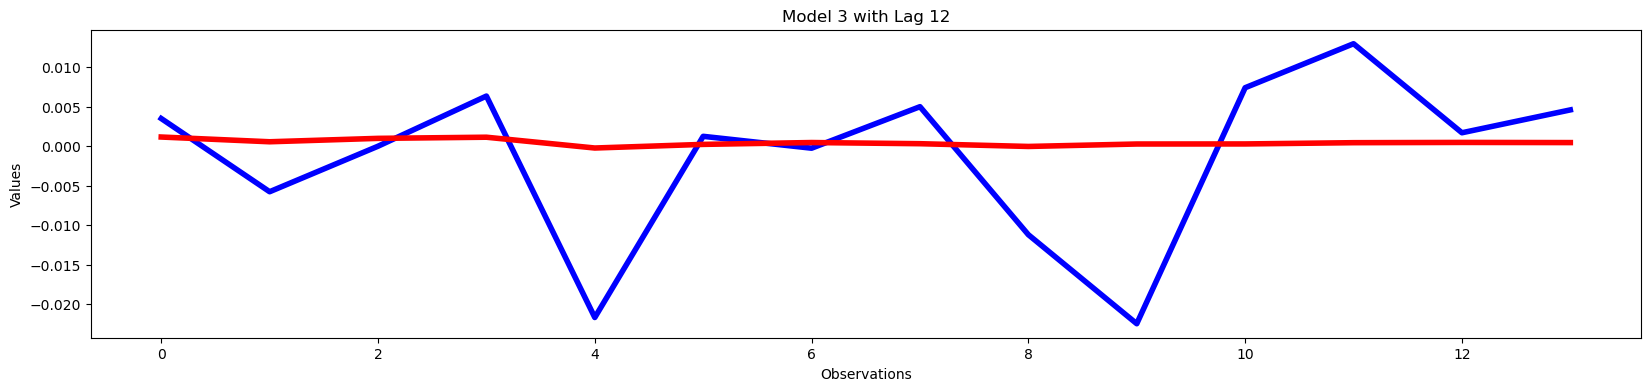

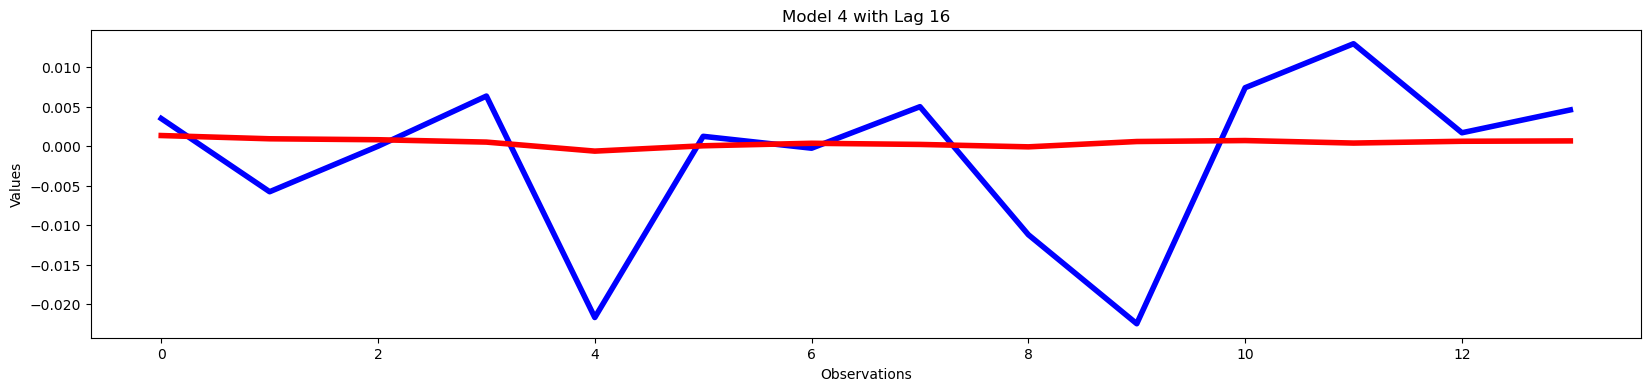

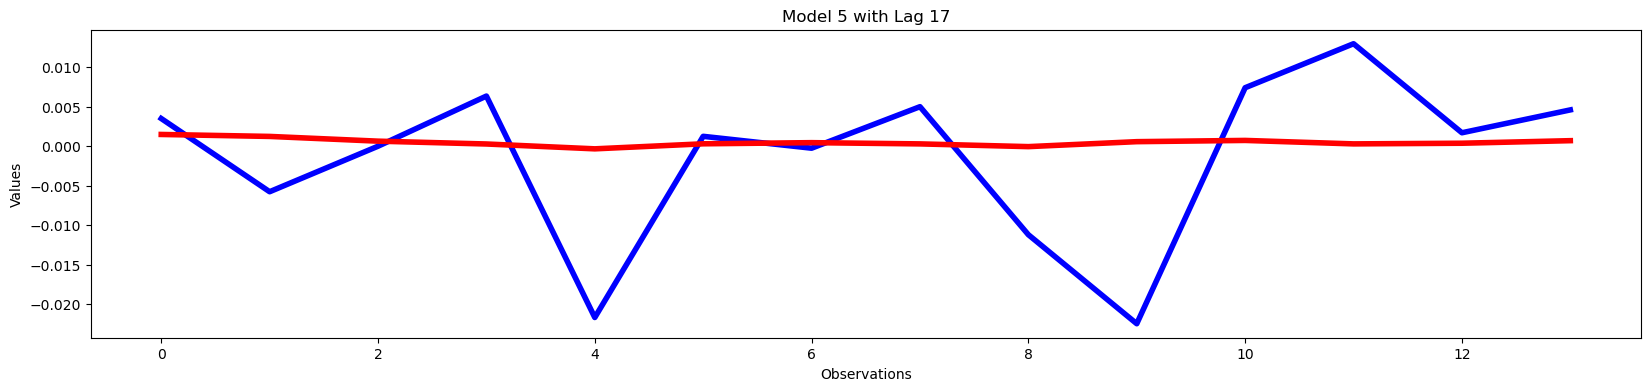

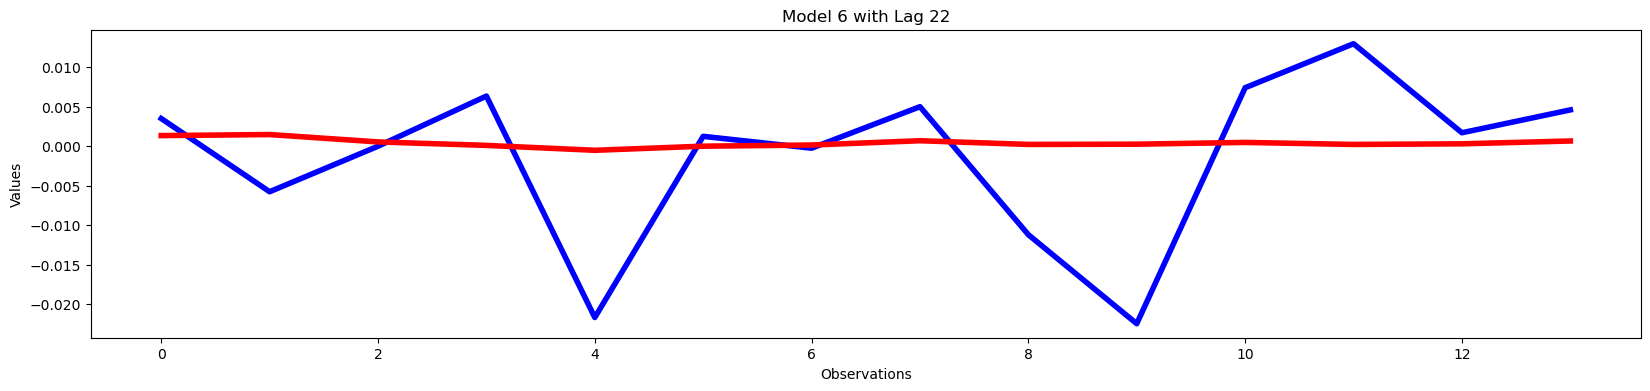

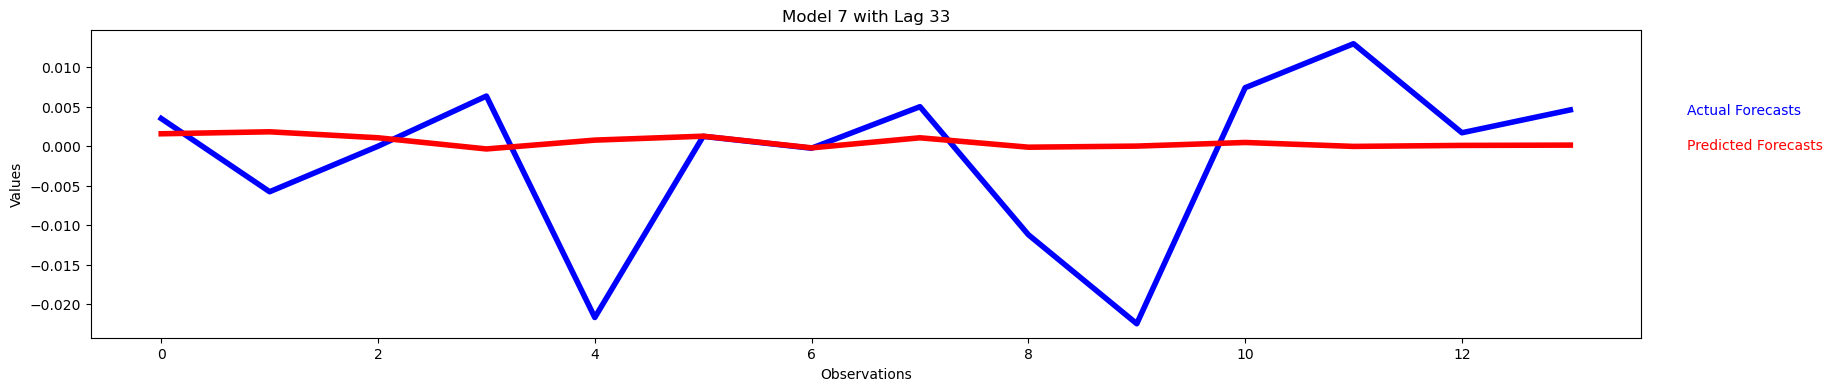

In [36]:
EvaluationMetric.plot_forecast(expected_forecast, predictions, lags_to_test)

### ARCH

In [37]:
from arch import arch_model

In [38]:
am = arch_model(aapl_returns.get_series())
am

NameError: name 'aapl_returns' is not defined

In [ ]:
res = am.fit()

In [ ]:
print(res.summary())

In [ ]:
res.plot(annualize="D")

### Follow-up
- What can we determine from this?
    - None of the models with the specified lag are performing well. Why?
- Which AR(p) lag performs the best?
    - Difficult to state. 
- Can we do better?
    - We must lol!